# Selecting neighborhood for a new wine store in Toronto.

##### Miguel Tamarit, April 2020

## 1. Introduction

### 1.1 Background

##### Wine is a product often consumed at home and in restaurants.
##### Restaurants in particular have few stock space so every day they must purchase products they use. The providers of wine for restaurants must be prepared to serve their customers in short time, so they preferably must have the store near their customers.
##### On other hand, the amount of wine people buy in a store is related to population in the neighborhood, and their income amount.

### 1.2 Problem

##### Data is widely available in this times, and it is the key to find the best places for any business to locate a new shop or office 
##### This project will enable data to predict the best neighborhoods to open a new wine store.

### 1.3 Interest

##### A retail store wants to open a store in Toronto. This company sell wines to both people directly in the shop and to restaurants. 
##### They want to open their store near their potential customers. 
##### They think the best place to start business in the city will be a neighborhood with as many restaurants as possible, with more population (where presumably their products would be consumed more often), and with more average income where their more expensive (and more profitable) products will sell better. 
##### They want me to find them several neighborhoods with this criteria, but finally will be they who select the final location.

## 2. Data acquisition and cleaning

### 2.1 Data sources

##### The population and income for every Toronto neighborhood can be found in wikipedia pages https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods 
##### Some web scrapping technics will be needed to get the data from this web page. The dataset is from several years ago, but this is not a quick changing data in percentage, so it will serve for purpose.
##### On the other hand The restaurants in every neighborhood can be obtained from FourSquare using their API.

### 2.2 Data cleaning

##### The income and population  for every Toronto neighborhood are columns in the referred wikipedia web page
##### Web scrapping is the technique to get this information from the page into a usable data frame

### 2.3 Feature selection

##### Data venues for Toronto neighborhood must be filtered to get only the restaurants, and summed to get the amount of them in every neighborhood. 
##### The income and population  for every Toronto neighborhood are columns in the referred wikipedia web page. The only information to take is the next 3 columns: the name of the neighborhood, the average income, and population
##### information tables from both sources must be combined into one table.

## 3. Data analysis

### 3.1 Get the population and income for every Toronto neighborhood 

##### Import libraries for the project

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import urllib.request

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

##### install bs4 for website scrapping

In [2]:
pip install bs4  #install bs4 for website scrapping

     |████████████████████████████████| 112kB 6.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [3]:
from bs4 import BeautifulSoup

##### Get the Toronto neighborhoods, their population and income from the wikipedia

In [4]:
url = "https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "html.parser")
table = soup.find('table', class_='wikitable sortable')

# set new lists for the 3 columns we are interested in from the web table
A=[]  # for neighborhood
B=[]  # for population
C=[]  # for average income

# move the table data to lists.
for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==13:
        A.append(cells[0].find(text=True))
        B.append(cells[3].find(text=True))
        C.append(cells[7].find(text=True))

# move the lists data to the dataframe columns
df=pd.DataFrame(A,columns=['Neighborhood'])
df['Population']=B
df['Average Income']=C

# remove the '\n' values in the columns
df['Neighborhood'] = df['Neighborhood'].str.replace('\n', '')
df['Neighborhood'] = df['Neighborhood'].str.replace("(", '')
df['Population'] = df['Population'].str.replace('\n', '')
df['Average Income'] = df['Average Income'].str.replace('\n', '')
df['Population'] = df['Population'].str.replace(',', '')
df['Average Income'] = df['Average Income'].str.replace(',', '')
df['Population'] = df['Population'].astype(int)
df['Average Income'] = df['Average Income'].astype(int)

# remove rows with de Borough column NaN
df.dropna(subset=['Population'])
df.dropna(subset=['Average Income'])
df.dropna(subset=['Neighborhood'])

# reset index after remove rows
df.reset_index(drop=True, inplace=True)

# Delete the rows with label 0 (toronto average)
df.drop([0,28,72,77,79,119,124,128], axis=0, inplace=True)

#df.drop(df.index[df['Neighborhood'] not in ['Clairville','Humber Bay Shores','Humbermede','Humewood–Cedarvale','Playter Estates','Regal Heights','Rockcliffe–Smythe']], inplace = True)

df.shape

(167, 3)

### Analyze toronto neighborhoods by Population

In [5]:
df.head()

,Neighborhood,Population,Average Income
1,Agincourt,44577,25750
2,Alderwood,11656,35239
3,Alexandra Park,4355,19687
4,Allenby,2513,245592
5,Amesbury,17318,27546


In [6]:
import matplotlib
import matplotlib.pyplot as plt

dfPopulation = df[['Neighborhood','Population']]
dfPopSort = dfPopulation.sort_values(['Population'], ascending=False)
dfPlot = dfPopSort.head(15)
dfPlot.set_index('Neighborhood', inplace = True)
dfPlot

,Population
Neighborhood,
Old East York,52220
Woburn,48507
Elia,48003
L'Amoreaux,45862
Agincourt,44577
Malvern,44324
Willowdale,43144
Downsview,36613
Newtonbrook,36046


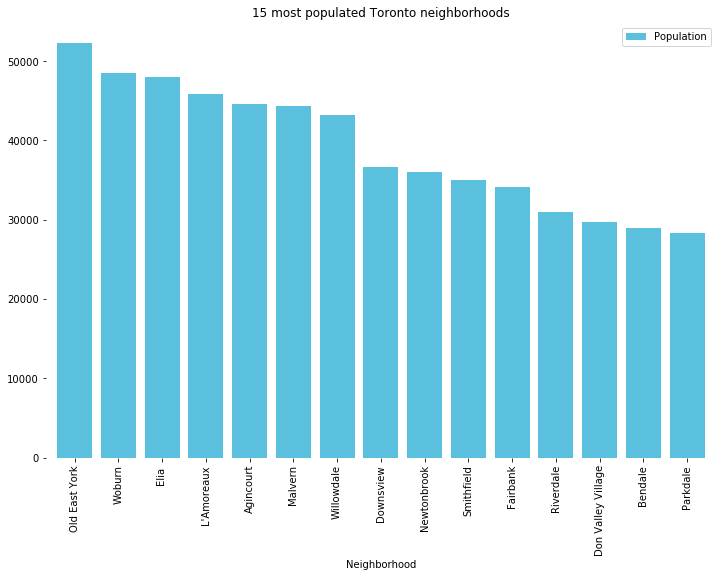

In [7]:
dfPlot.plot(kind='bar', color=['#5bc0de'], width=0.8, figsize=[12,8])
plt.title('15 most populated Toronto neighborhoods')
y = np.arange(0)
#plt.yticks(y, " ")
plt.box(on=None)
plt.rcParams.update({'font.size': 16})
plt.show()

### Analyze toronto neighborhoods by average income

In [8]:
dfAvIncome = df[['Neighborhood','Average Income']]
dfAvInSort = dfAvIncome.sort_values(['Average Income'], ascending=False)
dfPlotIncome = dfAvInSort.head(15)
dfPlotIncome.set_index('Neighborhood', inplace = True)
dfPlotIncome

,Average Income
Neighborhood,
Bridle Path,314107
Allenby,245592
Hoggs Hollow,222560
Lawrence Park,214110
Rosedale,213941
Moore Park,154825
Governor's Bridge,129904
Lytton Park,127356
South Hill,120453


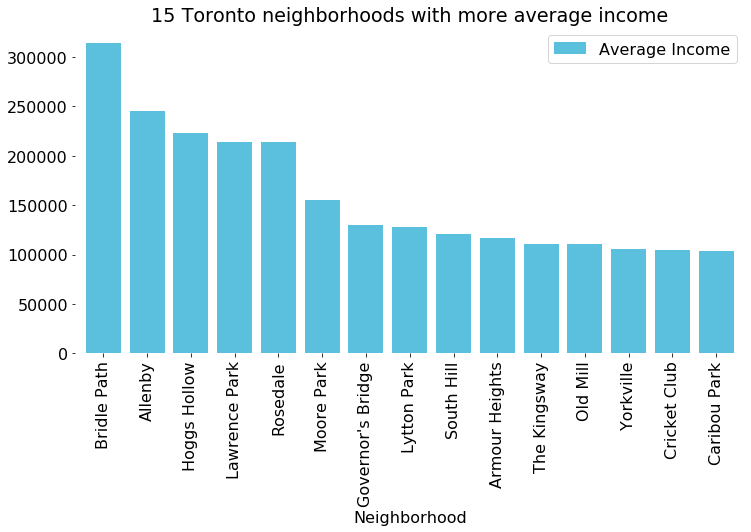

In [9]:
dfPlotIncome.plot(kind='bar', color=['#5bc0de'], width=0.8, figsize=[12,6])
plt.title('15 Toronto neighborhoods with more average income')
y = np.arange(0)
#plt.yticks(y, " ")
plt.box(on=None)
plt.rcParams.update({'font.size': 16})
plt.show()

##### Get coordinates of every neighborhood

In [10]:
CLIENT_ID = '*****' # Foursquare ID
CLIENT_SECRET = '****' # Foursquare Secret
VERSION = '20180604'

In [11]:
geolocator = Nominatim(user_agent="foursquare_agent")
lat=[]  # for latitude
lon=[]  # for longitude

for index, row in df.iterrows():
    # exclude neighborhoods with no geodata
    if row['Neighborhood'] not in ['Clairville','Humber Bay Shores','Humbermede','Humewood–Cedarvale','Playter Estates','Regal Heights','Rockcliffe–Smythe']:
        address = row['Neighborhood'] + ', Toronto'
        print(address)
        location = geolocator.geocode(address)
        print(location.latitude, location.longitude)
        lat.append(location.latitude)
        lon.append(location.longitude)

df['Latitude'] = lat
df['Longitude'] = lon

df.head()

Agincourt, Toronto
43.7853531 -79.2785494
Alderwood, Toronto
43.6017173 -79.5452325
Alexandra Park, Toronto
43.65075755 -79.40430754323067
Allenby, Toronto
43.7113509 -79.5534236
Amesbury, Toronto
43.7061619 -79.48349185404643
Armour Heights, Toronto
43.7439436 -79.4308512
Banbury, Toronto
43.7427961 -79.3699566407258
Bathurst Manor, Toronto
43.76389295 -79.45636693710946
Bay Street Corridor, Toronto
43.6644565 -79.3871893
Bayview Village, Toronto
43.7691966 -79.3766617
Bayview Woods – Steeles, Toronto
43.7981268 -79.3829726
Bedford Park, Toronto
43.7373876 -79.4109253
Bendale, Toronto
43.7535196 -79.2553355
Birch Cliff, Toronto
43.702112150000005 -79.26009053015676
Bloor West Village, Toronto
43.6493184 -79.4844358
Bracondale Hill, Toronto
43.6761954 -79.4280155
Branson, Toronto
43.771426 -79.44728711605052
Bridle Path, Toronto
43.7381512 -79.3725113
Brockton, Toronto
43.6509173 -79.4400216
Cabbagetown, Toronto
43.6644734 -79.3669861
Caribou Park, Toronto
43.7208504 -79.4152744
Carlet

,Neighborhood,Population,Average Income,Latitude,Longitude
1,Agincourt,44577,25750,43.785353,-79.278549
2,Alderwood,11656,35239,43.601717,-79.545232
3,Alexandra Park,4355,19687,43.650758,-79.404308
4,Allenby,2513,245592,43.711351,-79.553424
5,Amesbury,17318,27546,43.706162,-79.483492


##### set the query to find the restaurants

In [12]:
search_query = 'Restaurant'
LIMIT = 100
Restaurants = []
Neigborhoods = []

In [13]:
# funtion to get venues in each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, lat, lng, search_query, radius, LIMIT)
        num_venues = 0
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
                                                        CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        venues = requests.get(url).json()['response']['venues']
        
        for v in venues:
            num_venues = num_venues + 1
    
        print(num_venues)
        
        # return only relevant information for each nearby venue
        Neigborhoods.append(name)
        Restaurants.append(num_venues) 

# call the function on each neighborhood and create a new dataframe called toronto_venues
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

dfRest=pd.DataFrame()
dfRest['Neighborhood'] = Neigborhoods
dfRest['Restaurants'] = Restaurants

dfRest.head()

Agincourt 43.7853531 -79.2785494 Restaurant 500 100
18
Alderwood 43.6017173 -79.5452325 Restaurant 500 100
1
Alexandra Park 43.65075755 -79.40430754323067 Restaurant 500 100
25
Allenby 43.7113509 -79.5534236 Restaurant 500 100
3
Amesbury 43.7061619 -79.48349185404643 Restaurant 500 100
0
Armour Heights 43.7439436 -79.4308512 Restaurant 500 100
0
Banbury 43.7427961 -79.3699566407258 Restaurant 500 100
0
Bathurst Manor 43.76389295 -79.45636693710946 Restaurant 500 100
0
Bay Street Corridor 43.6644565 -79.3871893 Restaurant 500 100
18
Bayview Village 43.7691966 -79.3766617 Restaurant 500 100
0
Bayview Woods – Steeles 43.7981268 -79.3829726 Restaurant 500 100
0
Bedford Park 43.7373876 -79.4109253 Restaurant 500 100
0
Bendale 43.7535196 -79.2553355 Restaurant 500 100
0
Birch Cliff 43.702112150000005 -79.26009053015676 Restaurant 500 100
0
Bloor West Village 43.6493184 -79.4844358 Restaurant 500 100
5
Bracondale Hill 43.6761954 -79.4280155 Restaurant 500 100
1
Branson 43.771426 -79.447287116

,Neighborhood,Restaurants
0,Agincourt,18
1,Alderwood,1
2,Alexandra Park,25
3,Allenby,3
4,Amesbury,0


### Analyze toronto neighborhoods by number of restaurants

In [14]:
dfRestaurants = dfRest[['Neighborhood','Restaurants']]
dfRestSort = dfRestaurants.sort_values(['Restaurants'], ascending=False)
dfPlotRest = dfRestSort.head(15)
dfPlotRest.set_index('Neighborhood', inplace = True)
dfPlotRest

,Restaurants
Neighborhood,
Grange Park,48
Kensington Market,41
Financial District,38
Garden District,36
Fashion District,30
Discovery District,30
Yorkville,27
Alexandra Park,25
Church and Wellesley,21


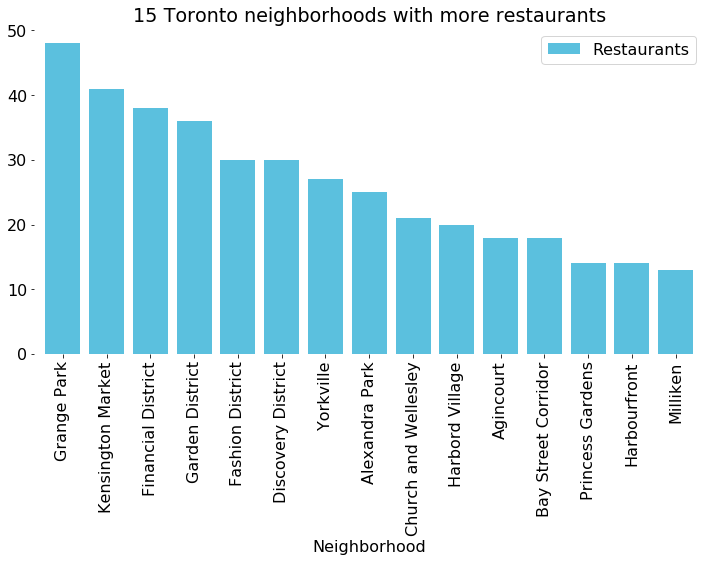

In [15]:
dfPlotRest.plot(kind='bar', color=['#5bc0de'], width=0.8, figsize=[12,6])
plt.title('15 Toronto neighborhoods with more restaurants')
y = np.arange(0)
#plt.yticks(y, " ")
plt.box(on=None)
plt.rcParams.update({'font.size': 16})
plt.show()

##### There is no way to see which neighborhoods are the ones that we could recommend, so we will use a clustering technique to get the solution.

### Merge the Data from neighborhoods with the number of restaurants they have

In [16]:
df2 = pd.merge(df, dfRest, on='Neighborhood')
df2.head()

,Neighborhood,Population,Average Income,Latitude,Longitude,Restaurants
0,Agincourt,44577,25750,43.785353,-79.278549,18
1,Alderwood,11656,35239,43.601717,-79.545232,1
2,Alexandra Park,4355,19687,43.650758,-79.404308,25
3,Allenby,2513,245592,43.711351,-79.553424,3
4,Amesbury,17318,27546,43.706162,-79.483492,0


In [17]:
df3 = df2[['Neighborhood','Population','Average Income','Restaurants']]
df3.head()

,Neighborhood,Population,Average Income,Restaurants
0,Agincourt,44577,25750,18
1,Alderwood,11656,35239,1
2,Alexandra Park,4355,19687,25
3,Allenby,2513,245592,3
4,Amesbury,17318,27546,0


##### Let's normalize the dataset before cluster process

In [18]:
from sklearn.preprocessing import StandardScaler

X = df3.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 2.95181013, -0.56853398,  1.70788553],
       [-0.22929278, -0.34571928, -0.44326222],
       [-0.93477659, -0.71090152,  2.59365224],
       [-1.11276607,  4.59365697, -0.19018601],
       [ 0.31781711, -0.52636144, -0.56980032],
       [-0.93197437,  1.56594587, -0.56980032],
       [-0.71388411,  0.99459722, -0.56980032],
       [ 0.08851796, -0.37084434, -0.56980032],
       [-0.89303313, -0.21988263,  1.70788553],
       [-0.16899667, -0.07537829, -0.56980032],
       [-0.07062898, -0.19905465, -0.56980032],
       [-0.02704958,  0.72474934, -0.56980032],
       [ 1.44131529, -0.4752425 , -0.56980032],
       [-0.17034947, -0.02341402, -0.56980032],
       [-0.85554132,  0.13186827,  0.06289019],
       [-0.83930775, -0.19623689, -0.44326222],
       [-0.58092346, -0.53551918, -0.44326222],
       [-1.20678548,  6.20248291, -0.56980032],
       [-0.48216925, -0.53307711, -0.44326222],
       [-0.28108559,  0.01023478,  0.5690426 ],
       [-0.95970671,  1.26190912, -0.569

##### Cluster neighborhoods

##### Fist look for the best k

In [19]:
pip install yellowbrick

     |████████████████████████████████| 266kB 6.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


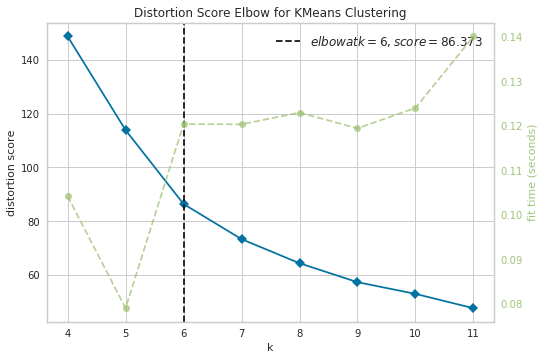

In [20]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(cluster_dataset)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure

#### The best K is 6

In [21]:
kclusters = 6
# run k-means clustering
k_means = KMeans(init="k-means++", n_clusters=kclusters, random_state=0, n_init=12)
k_means.fit(cluster_dataset)

# check cluster labels generated for each row in the dataframe
k_means.labels_[0:10]


array([4, 3, 2, 5, 0, 1, 1, 3, 2, 3], dtype=int32)

In [22]:
# add clustering labels
df3 = df2[['Neighborhood','Latitude','Longitude','Population','Average Income','Restaurants']]
df3.insert(0, 'Cluster Labels', k_means.labels_.astype(int))
df3
# cluster 0 is middle income, high population, no restaurants
# cluster 1 is high income, low population, no restaurants
# cluster 2 is middle or high income, low population, many restaurants
# cluster 3 is middle income, middle population, no restaurants
# cluster 4 is middle income, high population, few restaurants
# cluster 5 is high income, low populaton, few or no restaurants

,Cluster Labels,Neighborhood,Latitude,Longitude,Population,Average Income,Restaurants
0,4,Agincourt,43.785353,-79.278549,44577,25750,18
1,3,Alderwood,43.601717,-79.545232,11656,35239,1
2,2,Alexandra Park,43.650758,-79.404308,4355,19687,25
3,5,Allenby,43.711351,-79.553424,2513,245592,3
4,0,Amesbury,43.706162,-79.483492,17318,27546,0
5,1,Armour Heights,43.743944,-79.430851,4384,116651,0
6,1,Banbury,43.742796,-79.369957,6641,92319,0
7,3,Bathurst Manor,43.763893,-79.456367,14945,34169,0
8,2,Bay Street Corridor,43.664457,-79.387189,4787,40598,18
9,3,Bayview Village,43.769197,-79.376662,12280,46752,0


##### Visualize the resulting clusters

In [23]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df3['Latitude'], df3['Longitude'], df3['Neighborhood'], df3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.
